In [3]:
from py_process_data import process_dataset, parsing
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from shapely.geometry import Point
from shapely.geometry import Polygon
%matplotlib inline

In [8]:
def find_pixels_between_contours():
    """
    Find the area between outside and inside contours. I am using hard coded image names just to prove the concept.
    Since I need to extract the contours. I didn't want to change the pipeline to output contours as well.
    """
    dicom_file = parsing.parse_dicom_file('../final_data/dicoms/SCD0000101/59.dcm')
    o_contours = parsing.parse_contour_file(
        '../final_data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0059-ocontour-manual.txt')
    i_contours = parsing.parse_contour_file(
        '../final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0059-icontour-manual.txt')
    o_masks = parsing.poly_to_mask(o_contours, dicom_file.shape[0], dicom_file.shape[1])
    i_masks = parsing.poly_to_mask(i_contours, dicom_file.shape[0], dicom_file.shape[1])
    diff_masks = o_masks ^ i_masks
    #plt.imshow(diff_masks)
    # Get all pixels inside i-contours
    inside_pixels = []
    for p in np.argwhere(i_masks):
        inside_pixels.append(dicom_file[p[0]][p[1]])
    
    #Get all the pixels in between i-contours and o-contours
    diff_pixels = []
    for p in np.argwhere(diff_masks):
        diff_pixels.append(dicom_file[p[0]][p[1]])
    print("Mean of in between and inside pixels {}, {}".format(np.mean(diff_pixels), np.mean(inside_pixels)))
    print("Standard deviation of in-between pixels and inside pixels {}. {}".format(np.std(diff_pixels), np.std(diff_pixels)))
    return inside_pixels, diff_pixels
inside_pixels, diff_pixels = find_pixels_between_contours()

Mean of in between and inside pixels 89.62264150943396, 246.19390862944164
Standard deviation of in-between pixels and inside pixels 44.8337500967676. 44.8337500967676


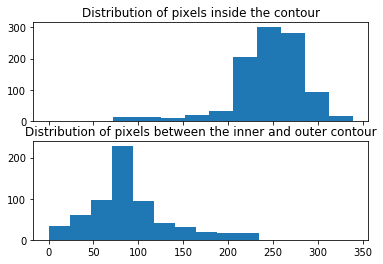

In [6]:
def plot_histograms(inside_pixels, in_between_pixels):
    """
    Given the inside pixels and the in-between pixels, plot the respective histograms as subplots
    """
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].hist(inside_pixels)
    axarr[0].set_title('Distribution of pixels inside the contour')
    axarr[1].set_title('Distribution of pixels between the inner and outer contour')
    axarr[1].hist(diff_pixels)
plot_histograms(inside_pixels, diff_pixels)

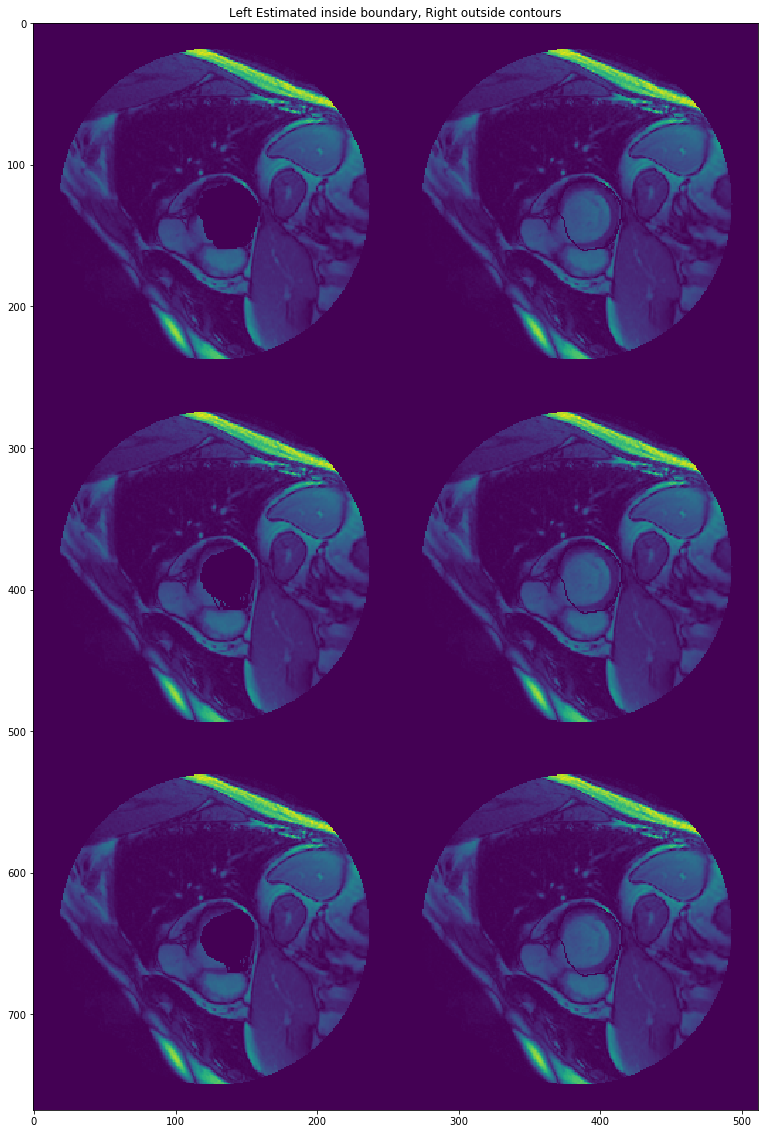

In [11]:
def find_i_c_given_o_c(thresholds):
    """
    Trying to use a simple thresholding algorithm to estimate i-contours given o-contours
    The logic here is simple - we know the pixel intensities inside the i-contour, we know
    the pixel intensities on the contour. 
    The intensities vary but the general consensus is that the difference between these 
    intensities can be thresholded around the mean differences. I've attempted to show that 
    this thresholding isn't always accurate. 
    As we can see in the third row, the chosen threshold yeilds a slightly better 
    estimate of the inner contour
    """
    image = parsing.parse_dicom_file('../final_data/dicoms/SCD0000101/59.dcm')
    o_contours = parsing.parse_contour_file(
        '../final_data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0059-ocontour-manual.txt')
    o_region = Polygon(o_contours)
    im_copy = np.copy(image)
    points_inside = []
    for index, pixel in np.ndenumerate(image):
        # Unpack the index.
        row, col = index
        # We only need to look at spatial pixel data for one of the four channels.
        point = Point(row, col)
        if o_region.contains(point):
            points_inside.append((row, col))
    
    new_poly = []
    for p in points_inside:
        for c in o_contours:
            r = image[int(p[0]), int(p[1])] - image[int(c[0]), int(c[1])] 
            if r in range(thresholds[0], thresholds[1]):
                new_poly.append(p)
    new_poly = list(set(new_poly))
    img_1 = Image.fromarray(np.copy(image))
    img_2 = Image.fromarray(np.copy(image))
    ImageDraw.Draw(img_1).polygon(xy=new_poly, outline=1, fill=None)
    ImageDraw.Draw(img_2).polygon(xy=o_contours, outline=5, fill=None)
    return np.hstack([img_1, img_2])
    
plt.figure(figsize=(20,20))
thresholds = [(60, 100), (140, 160), (150, 170)]

plt.title("Left Estimated inside boundary, Right outside contours")
plt.imshow(np.vstack([find_i_c_given_o_c(t) for t in thresholds]))